In [1]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml

MAX_JETS = 6
PLOTS_DIR = f"plots/feature_plots/"
CONFIG_PATH = "../config/workspace_config.yaml"
import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
plt.rcParams.update({"font.size": 16})

In [2]:
load_config = get_load_config_from_yaml(CONFIG_PATH)

DataProcessor = DataPreprocessor(load_config)

with open(CONFIG_PATH, "r") as file:
    load_config = yaml.safe_load(file)

data_config = DataProcessor.load_from_npz("../../DATA/nominal.npz")

In [5]:
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.1)

In [6]:
N_jets = DataProcessor.get_feature_data("non_training", "N_jets")

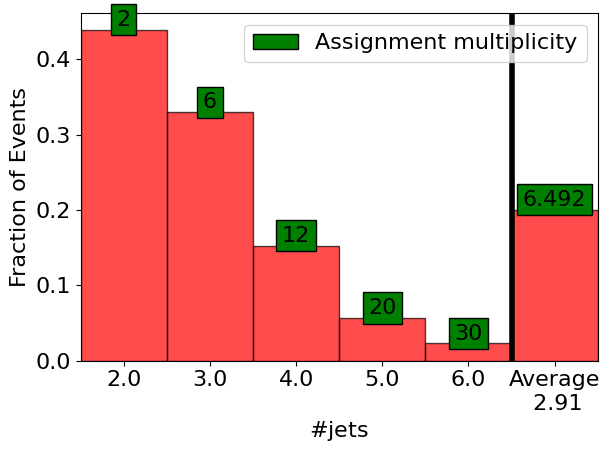

In [7]:
def assign_multiplicty(n):
    return n * (n - 1)


import matplotlib.patches as mpatches

n_bins = MAX_JETS - 1
fig, ax = plt.subplots()
hist, bins = np.histogram(N_jets, bins=n_bins, range=(2, 2 + n_bins), density=True)
assign_multiplicties = assign_multiplicty(bins[:-1])
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = np.concatenate([bin_centers, [bin_centers[-1] + 1]])
assign_multiplicties = np.concatenate(
    [assign_multiplicties, [np.dot(assign_multiplicties, hist)]]
)
xtick_labels = np.concatenate(
    [[f"{bins[i]}" for i in range(n_bins)], [f"Average\n {np.mean(N_jets):.2f}"]]
)

hist = np.concatenate([hist, [1 / n_bins]])


bar = ax.bar(
    bin_centers,
    width=1,
    height=hist,
    align="center",
    edgecolor="black",
    color="red",
    alpha=0.7,
)
for index, rect in enumerate(bar):
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width() / 2.0,
        height,
        (
            f"{assign_multiplicties[index]:.0f}"
            if index < n_bins
            else f"{assign_multiplicties[index]:.3f}"
        ),
        ha="center",
        va="bottom",
        color="black",
        bbox=dict(facecolor="green"),
    )
assign_label = ", ".join([f"{v:.3f}" for v in assign_multiplicties])

# --- create custom legend handles ---
bar_patch = mpatches.Patch(
    color="red", alpha=0.7, label="Reconstructed Jet Multiplicity"
)
green_box = mpatches.Patch(
    facecolor="green", edgecolor="black", label="Assignment multiplicity"
)

legend = ax.legend(
    handles=[green_box],
    loc="upper right",
    frameon=True,
)

# continue with your axis setup
ax.axvline(x=bins[-1], color="black", linewidth=4)
ax.set_xticks(bin_centers)
ax.set_xticklabels(xtick_labels)
ax.set_xlim(2, 2 + n_bins + 1)
ax.set_ylabel("Fraction of Events")
ax.set_xlabel(r"$\#\text{jets}$")
fig.tight_layout()
fig.savefig(PLOTS_DIR + "Jet_multiplicity.pdf")

In [8]:
def compute_closest_non_matching_jet(data_dict, data_config: DataConfig):
    padding_value = data_config.padding_value
    jet_eta = data_dict["jet"][:, :, 1]
    jet_phi = data_dict["jet"][:, :, 2]
    lep_eta = data_dict["lepton"][:, :, 1]
    lep_phi = data_dict["lepton"][:, :, 2]
    labels = data_dict["assignment_labels"]
    compute_closest_non_matching_jet = np.full((jet_eta.shape[0], 2), -1, dtype=float)
    for i in range(jet_eta.shape[0]):
        for lep_idx in range(2):
            min_dR = float("inf")
            match_dR = -1
            for jet_idx in range(jet_eta.shape[1]):
                if jet_eta[i, jet_idx] == padding_value:
                    continue
                if labels[i, jet_idx, lep_idx]:
                    match_dR = np.sqrt(
                        (jet_eta[i, jet_idx] - lep_eta[i, lep_idx]) ** 2
                        + (jet_phi[i, jet_idx] - lep_phi[i, lep_idx]) ** 2
                    )
                    continue
                dR = np.sqrt(
                    (jet_eta[i, jet_idx] - lep_eta[i, lep_idx]) ** 2
                    + (jet_phi[i, jet_idx] - lep_phi[i, lep_idx]) ** 2
                )
                if dR < min_dR and not labels[i, jet_idx, lep_idx]:
                    min_dR = dR
            compute_closest_non_matching_jet[i, lep_idx] = min_dR - match_dR
    return np.min(compute_closest_non_matching_jet, axis=1)

In [9]:
import core.DataPlotting as DataPlotting

reload(DataPlotting)
data_plotter = DataPlotting.DataPlotter(DataProcessor, plots_dir=PLOTS_DIR)
data_plotter.add_feature(compute_closest_non_matching_jet, name="closest_non_matching")

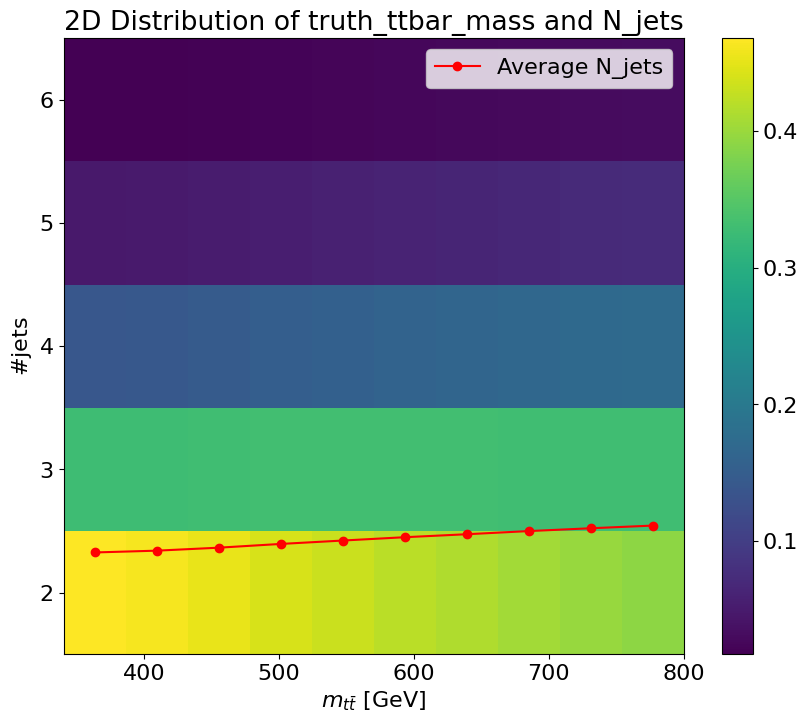

In [10]:
fig, ax = data_plotter.plot_2d_feature_distribution(
    "non_training",
    "truth_ttbar_mass",
    "non_training",
    "N_jets",
    plot_average=True,
    normalise="x",
    bins=[10, 5],
    range=[[340e3, 800e3], [2, MAX_JETS + 1]],
)
x_ticks = ax.get_xticks()
x_tick_labels = [f"{int(x/1e3)}" for x in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xlim(340e3, 800e3)
ax.set_xticklabels(x_tick_labels)
ax.set_xlabel(r"$m_{t\bar{t}}$ [GeV]")
ax.set_ylabel(r"$\#\text{jets}$")
y_ticks = ax.get_yticks()
y_tick_labels = [f"{int(y)}" for y in y_ticks[:-1]]
ax.set_yticks([(y_ticks[i] + y_ticks[i + 1]) / 2 for i in range(len(y_ticks) - 1)])
ax.set_yticklabels(y_tick_labels)
fig.savefig(PLOTS_DIR + "N_jets_vs_ttbar_mass.pdf")

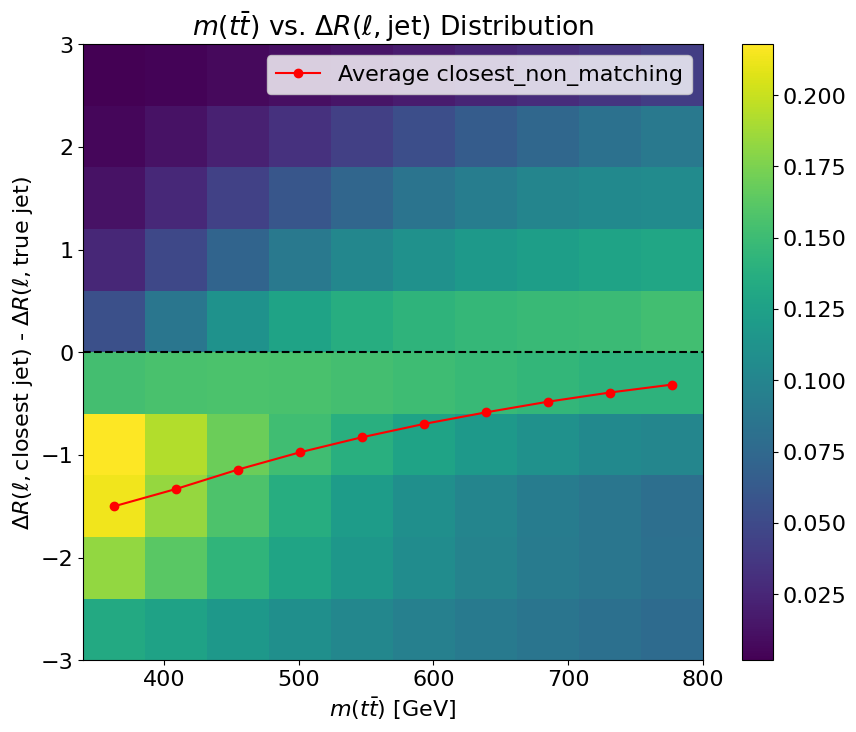

In [11]:
fig, ax = data_plotter.plot_2d_feature_distribution(
    "non_training",
    "truth_ttbar_mass",
    "custom",
    "closest_non_matching",
    plot_average=True,
    normalise="x",
    bins=10,
    range=[[340e3, 800e3], [-3, 3]],
    density=True,
)
x_ticks = ax.get_xticks()
x_tick_labels = [f"{int(tick/1e3)}" for tick in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.axhline(y=0, color="black", linestyle="--")
ax.set_xlim(340e3, 800e3)
ax.set_xlabel(r"$m(t\bar{t})$ [GeV]")
ax.set_ylabel(r"$\Delta R(\ell,\text{closest jet})$ - $\Delta R(\ell,\text{true jet})$")
ax.set_title(r"$m(t\bar{t})$ vs. $\Delta R(\ell, \text{jet})$ Distribution")
plt.savefig(f"{PLOTS_DIR}/ttbar_mass_vs_deltaR_lep_nonmatch.pdf")

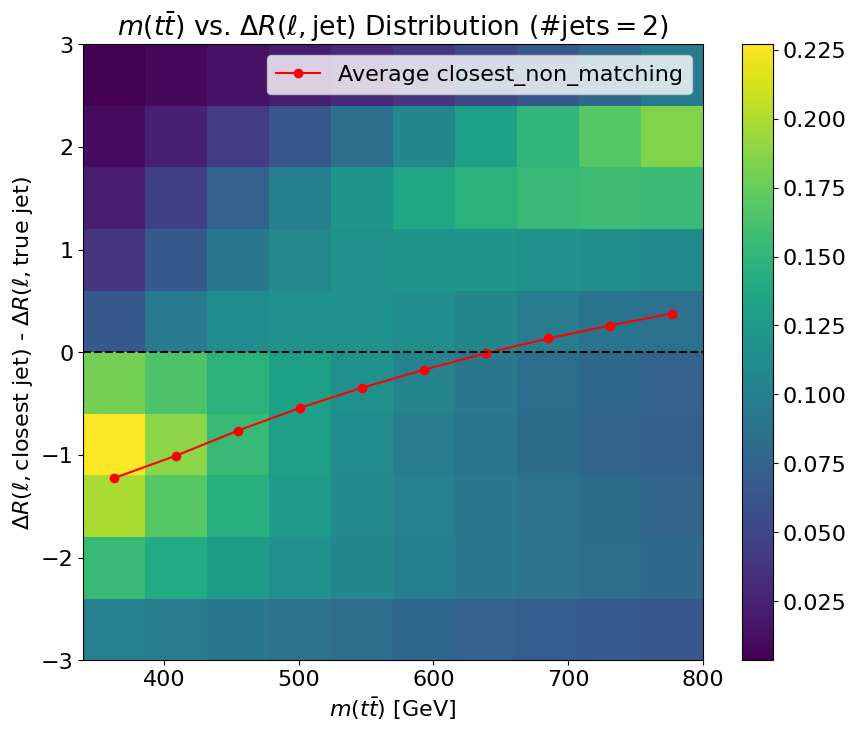

In [12]:
data_plotter.register_data_cut("non_training", "N_jets", lambda x: x == 2)
fig, ax = data_plotter.plot_2d_feature_distribution(
    "non_training",
    "truth_ttbar_mass",
    "custom",
    "closest_non_matching",
    plot_average=True,
    normalise="x",
    bins=10,
    range=[[340e3, 800e3], [-3, 3]],
    density=True,
)
x_ticks = ax.get_xticks()
x_tick_labels = [f"{int(tick/1e3)}" for tick in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.axhline(y=0, color="black", linestyle="--")
ax.set_xlim(340e3, 800e3)
ax.set_xlabel(r"$m(t\bar{t})$ [GeV]")
ax.set_ylabel(r"$\Delta R(\ell,\text{closest jet})$ - $\Delta R(\ell,\text{true jet})$")
ax.set_title(
    r"$m(t\bar{t})$ vs. $\Delta R(\ell, \text{jet})$ Distribution ($\# \text{jets} = 2$)"
)
plt.savefig(f"{PLOTS_DIR}/ttbar_mass_vs_deltaR_lep_nonmatch_n_jet_2.pdf")

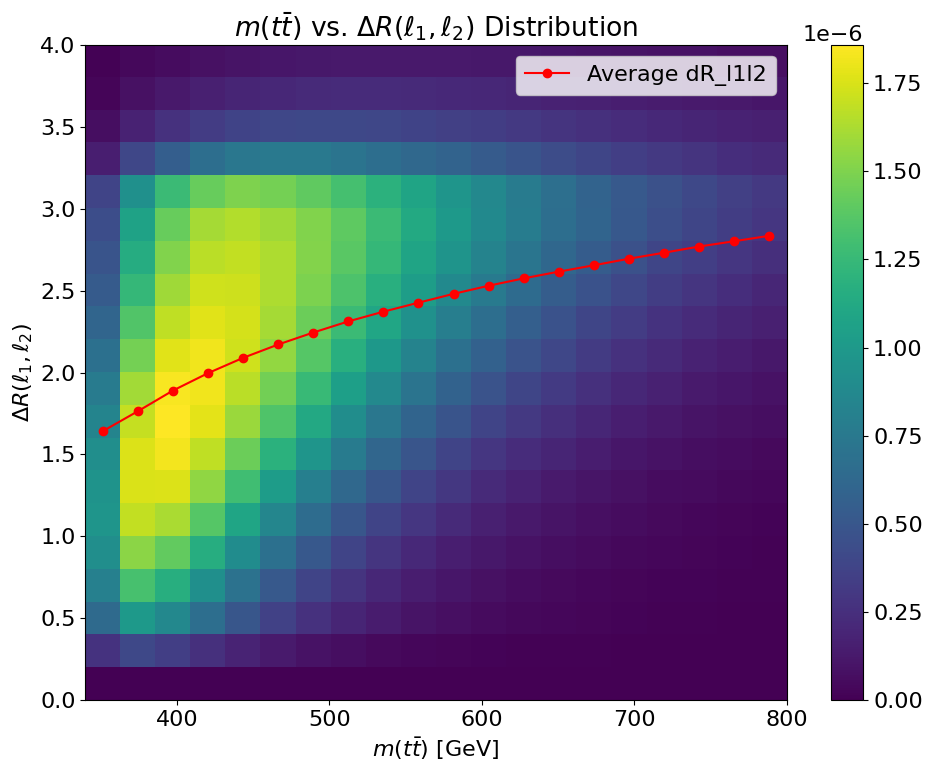

In [13]:
data_plotter.reset_data_cuts()
fig, ax = data_plotter.plot_2d_feature_distribution(
    "non_training",
    "truth_ttbar_mass",
    "non_training",
    "dR_l1l2",
    bins=(20, 20),
    plot_average=True,
    range=[[340e3, 800e3], [0, 4]],
    density=True,
)
x_ticks = ax.get_xticks()
x_tick_labels = [f"{int(tick/1e3)}" for tick in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.set_xlim(340e3, 800e3)
ax.set_xlabel(r"$m(t\bar{t})$ [GeV]")
ax.set_ylabel(r"$\Delta R(\ell_1, \ell_2)$")
ax.set_title(r"$m(t\bar{t})$ vs. $\Delta R(\ell_1, \ell_2)$ Distribution")
# fig.suptitle(r"$m(t\bar{t})$ vs. $\Delta R(\ell_1, \ell_2)$ Distribution")
fig.tight_layout()
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_vs_dR_l1l2.pdf")

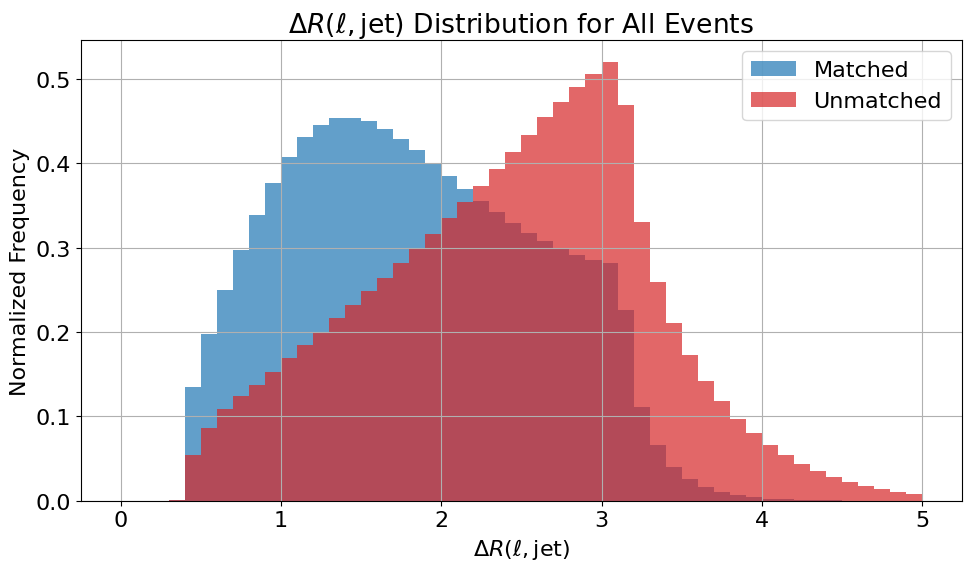

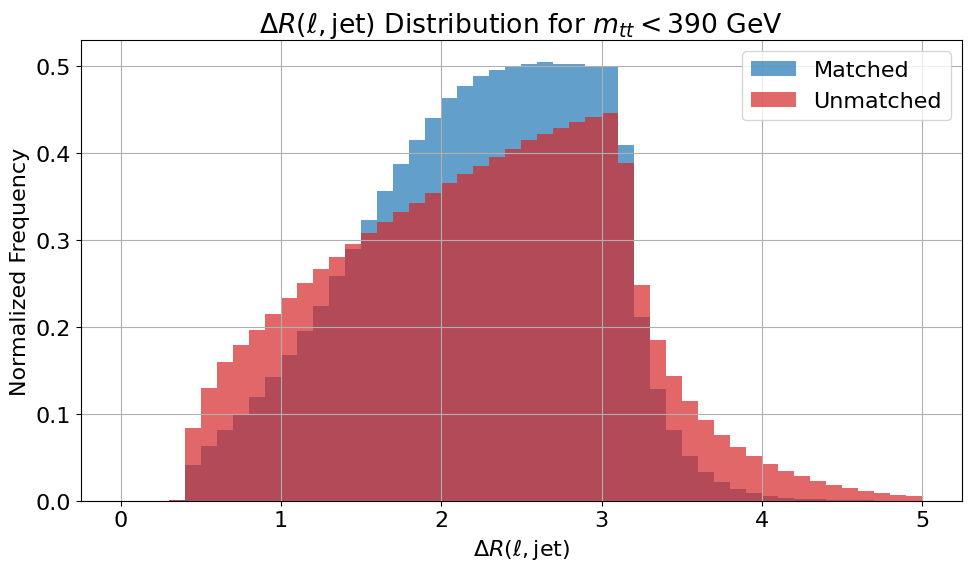

In [14]:
def delta_R(jet_features, lepton_features):
    delta_eta = jet_features[1] - lepton_features[1]
    delta_phi = jet_features[2] - lepton_features[2]
    delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)


def invariant_mass(jet_features, lepton_features):
    jet_e = jet_features[3]
    jet_px = jet_features[0] * np.cos(jet_features[2])
    jet_py = jet_features[0] * np.sin(jet_features[2])
    jet_pz = jet_features[0] * np.sinh(jet_features[1])

    lep_e = lepton_features[3]
    lep_px = lepton_features[0] * np.cos(lepton_features[2])
    lep_py = lepton_features[0] * np.sin(lepton_features[2])
    lep_pz = lepton_features[0] * np.sinh(lepton_features[1])

    total_e = jet_e + lep_e
    total_px = jet_px + lep_px
    total_py = jet_py + lep_py
    total_pz = jet_pz + lep_pz

    return np.sqrt(total_e**2 - total_px**2 - total_py**2 - total_pz**2)


fig, ax = data_plotter.plot_relational_jet_lepton_features(
    delta_R, r"$\Delta R(\ell, \text{jet})$", bins=50, range=(0, 5)
)
ax.set_title(r"$\Delta R(\ell, \text{jet})$ Distribution for All Events")
fig.tight_layout()
fig.savefig(PLOTS_DIR + "relational_jet_lepton_deltaR_distribution.pdf")

# For m_tt < 390 GeV
data_plotter.register_data_cut("non_training", "truth_ttbar_mass", lambda x: x < 390e3)
fig, ax = data_plotter.plot_relational_jet_lepton_features(
    delta_R, r"$\Delta R(\ell, \text{jet})$", bins=50, range=(0, 5)
)
ax.set_title(r"$\Delta R(\ell,\text{jet})$ Distribution for $m_{tt} < 390$ GeV")
fig.tight_layout()
fig.savefig(PLOTS_DIR + "relational_jet_lepton_deltaR_distribution_m_tt_390GeV.pdf")